In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as dsfh
import missingno as msno
from pyaxis import pyaxis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
import statsmodels.api as sm
#import statsmodels.api as sm #statsmodels is used for creating linear regression models
from sklearn.model_selection import train_test_split #creating testing and training data
from sklearn.metrics import roc_auc_score #evaluate model performance
import predhelp as ph
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
fp = r"../data/px-x-1003020000_101.px" 

In [2]:
saanen = ph.get_region(fp,"Saanen","St. Moritz","Crans-Montana","Zermatt")
gdp = ph.gdp_clean("../data/gdpPC.csv")
#ppi = ph.ppi_clean("../data/Producer_price_indices.csv")
#xrate = ph.forex_clean("../data/SNB_Xrate_20y.csv")

/Users/schuler/Documents/GitHub.nosync/dsfgp/code/predhelp.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_regions[i][regions[i]].rename(columns = {'Jahr' : 'year', 'Monat': 'month'}, inplace = True)
/Users/schuler/Documents/GitHub.nosync/dsfgp/code/predhelp.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_regions[i][regions[i]]['DATE'] = pd.to_datetime(dict_regions[i][regions[i]][['year','month']].assign(DAY = 1))
/Users/schuler/Documents/GitHub.nosync/dsfgp/code/predhelp.py:349: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [31]:
weather_chd = ph.weather_clean("../data/WeatherBetter/chd.csv")
weather_gsg = ph.weather_clean("../data/WeatherBetter/gsg.csv")
weather_zwe = ph.weather_clean("../data/WeatherBetter/zwe.csv")

In [22]:
xrate = pd.read_csv("../data/cleaned data/exchangerate.csv")
ppi = pd.read_csv("../data/cleaned data/PPI.csv")
unemployment = pd.read_csv("../data/cleaned data/unemployment1.csv")
saanen.drop(columns="Chile", inplace=True)

In [35]:
total_df = pd.concat([saanen, gdp, xrate, ppi, unemployment, weather_chd, weather_gsg, weather_zwe], axis=1, verify_integrity=False, copy=False).drop_duplicates()
total_df = total_df.loc[:,~total_df.columns.duplicated()].copy()
total_df.drop(columns="Unnamed: 0", inplace=True)


In [3]:
saanen

,DATE,Argentina,Australien,Austria,Bahrain,Belarus,Belgium,Brasil,Bulgaria,Canada,...,Taiwan,Thailand,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,guests-St. Moritz,guests-Crans-Montana,guests-Zermatt
0,2013-01-01,8.0,218.0,98.0,10.0,32.0,721.0,331.0,9.0,159.0,...,0.0,759.0,269.0,237.0,179.0,1610.0,1059.0,96769.0,21838.0,141988.0
1,2013-02-01,12.0,13.0,180.0,21.0,2.0,2023.0,323.0,176.0,82.0,...,37.0,132.0,299.0,62.0,153.0,3210.0,1317.0,92543.0,30924.0,155304.0
2,2013-03-01,14.0,18.0,37.0,10.0,0.0,819.0,77.0,8.0,58.0,...,0.0,25.0,46.0,119.0,100.0,1150.0,792.0,91716.0,19072.0,177233.0
3,2013-04-01,4.0,34.0,5.0,14.0,0.0,545.0,16.0,0.0,2.0,...,8.0,65.0,0.0,2.0,23.0,87.0,105.0,18222.0,7624.0,82763.0
4,2013-05-01,0.0,17.0,20.0,0.0,375.0,233.0,6.0,0.0,24.0,...,0.0,30.0,3.0,6.0,1.0,287.0,131.0,17055.0,3479.0,34342.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2022-05-01,0.0,10.0,32.0,0.0,0.0,60.0,13.0,3.0,36.0,...,0.0,11.0,8.0,32.0,39.0,225.0,276.0,20174.0,NaN,47874.0
113,2022-06-01,11.0,36.0,192.0,9.0,2.0,175.0,13.0,0.0,97.0,...,0.0,43.0,13.0,32.0,136.0,607.0,1206.0,54310.0,NaN,88614.0
114,2022-07-01,31.0,271.0,156.0,62.0,2.0,555.0,240.0,18.0,276.0,...,25.0,189.0,89.0,39.0,1154.0,1427.0,2732.0,101131.0,NaN,154503.0
115,2022-08-01,68.0,131.0,123.0,32.0,8.0,365.0,106.0,9.0,121.0,...,12.0,37.0,127.0,35.0,1378.0,2320.0,2156.0,107316.0,NaN,146419.0


In [45]:
total_df.dtypes

DATE                        datetime64[ns]
Argentina                          float64
Australien                         float64
Austria                            float64
Bahrain                            float64
                                 ...      
cm avg. snowheight - zwe            object
mm rain - zwe                      float64
days rain >1mm - zwe                 int64
days rain >10mm - zwe                int64
days rain >100mm - zwe               int64
Length: 234, dtype: object

In [106]:
#total_df["Chile"].sum()/214
#sns.scatterplot(total_df, x="FRA_GDP", y="France")

X = total_df["FRA_GDP"]
y = total_df["France"]
beta = [5.0, 0.5, 0.5, -0.02]
#y_true = np.dot(X, beta)

olsmod = sm.OLS(y, X)
olsres = olsmod.fit()
print(olsres.summary())

ypred = olsres.predict(X)

                                 OLS Regression Results                                
Dep. Variable:                 France   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.565
Method:                 Least Squares   F-statistic:                              153.2
Date:                Wed, 30 Nov 2022   Prob (F-statistic):                    6.07e-23
Time:                        01:01:01   Log-Likelihood:                         -1001.9
No. Observations:                 117   AIC:                                      2006.
Df Residuals:                     116   BIC:                                      2008.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

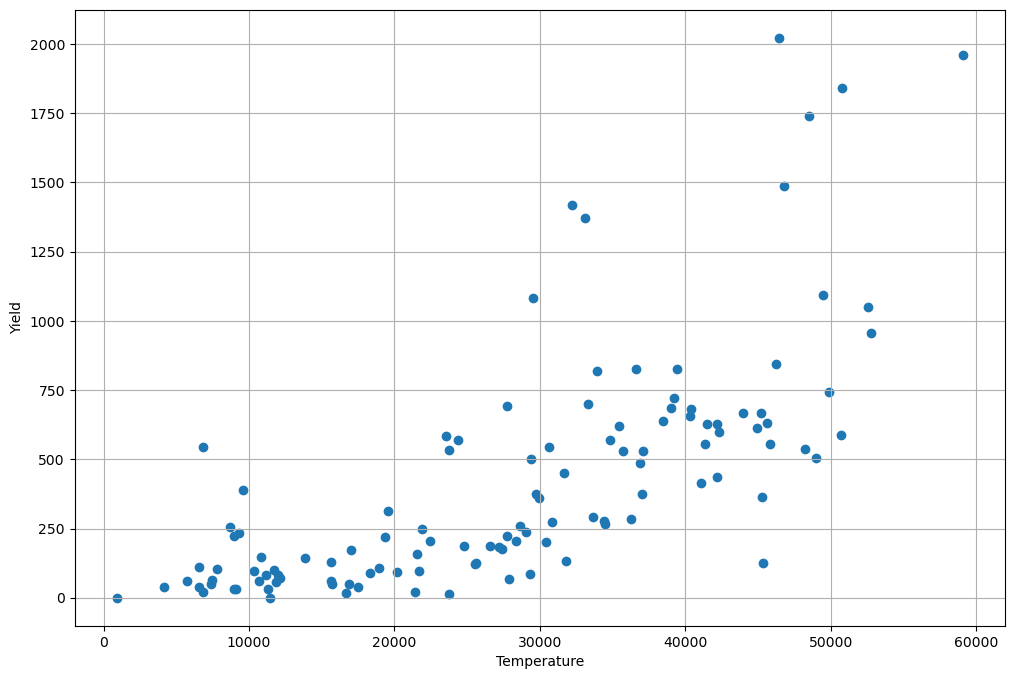

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(total_df["Herkunftsland - Total"], total_df["Belgium"])
# Label axes
ax.set_xlabel("Temperature")
ax.set_ylabel("Yield")
# Add a grid
ax.grid(True)

In [51]:
total_df

,DATE,Argentina,Australien,Austria,Bahrain,Belarus,Belgium,Brasil,Bulgaria,Canada,...,MEX_unemprate,NLD_unemprate,NOR_unemprate,POL_unemprate,PRT_unemprate,SVK_unemprate,SVN_unemprate,SWE_unemprate,TUR_unemprate,USA_unemprate
0,2013-01-01,8.0,218.0,98.0,10.0,32.0,721.0,331.0,9.0,159.0,...,5.208234,7.5,3.8,10.8,18.3,14.2,10.2,8.1,8.8,8.0
1,2013-02-01,12.0,13.0,180.0,21.0,2.0,2023.0,323.0,176.0,82.0,...,4.848728,7.7,4.0,10.9,18.2,14.2,10.6,8.2,8.8,7.7
2,2013-03-01,14.0,18.0,37.0,10.0,0.0,819.0,77.0,8.0,58.0,...,4.907551,7.9,4.1,10.9,18.1,14.2,10.8,8.5,9.0,7.5
3,2013-04-01,4.0,34.0,5.0,14.0,0.0,545.0,16.0,0.0,2.0,...,5.144341,8.0,4.1,11.0,17.9,14.2,10.8,8.4,9.1,7.6
4,2013-05-01,0.0,17.0,20.0,0.0,375.0,233.0,6.0,0.0,24.0,...,5.085738,8.1,3.9,10.9,17.7,14.2,10.6,8.0,9.0,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2022-05-01,0.0,10.0,32.0,0.0,0.0,60.0,13.0,3.0,36.0,...,3.365771,3.3,3.8,2.7,6.0,6.2,4.5,7.7,10.7,3.6
113,2022-06-01,11.0,36.0,192.0,9.0,2.0,175.0,13.0,0.0,97.0,...,3.330639,3.4,3.0,2.7,6.0,6.1,4.4,7.6,10.4,3.6
114,2022-07-01,31.0,271.0,156.0,62.0,2.0,555.0,240.0,18.0,276.0,...,3.261059,3.6,2.8,2.6,6.0,6.0,4.2,7.0,10.2,3.5
115,2022-08-01,68.0,131.0,123.0,32.0,8.0,365.0,106.0,9.0,121.0,...,3.262605,3.8,3.5,2.6,6.0,5.9,4.1,6.9,9.8,3.7


In [81]:

prediction = total_df[["Herkunftsland - Total", "Belgium"]]
# Define the estimator
ols1 = LinearRegression() 
prediction.sort_values("Herkunftsland - Total", inplace=True)
X, y = prediction[["Herkunftsland - Total"]], prediction["Belgium"]
prediction


/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/ipykernel_34729/2800242824.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction.sort_values("Herkunftsland - Total", inplace=True)


,Herkunftsland - Total,Belgium
87,930.0,0.0
75,4152.0,38.0
39,5723.0,62.0
46,6541.0,38.0
63,6572.0,112.0
...,...,...
103,50720.0,587.0
61,50799.0,1842.0
73,52540.0,1050.0
109,52757.0,957.0


In [82]:
ols1.fit(X, y)
# Add the predictions to our `crops` dataframe

prediction["pred"] = ols1.predict(X)

# Get value of constant and coefficient
print(f"constant: {ols1.intercept_:.2f}, coefficient: {ols1.coef_[0]:.7f}.")


constant: -174.17, coefficient: 0.0213468.


/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/ipykernel_34729/2744612607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction["pred"] = ols1.predict(X)


NameError: name 'ypred' is not defined

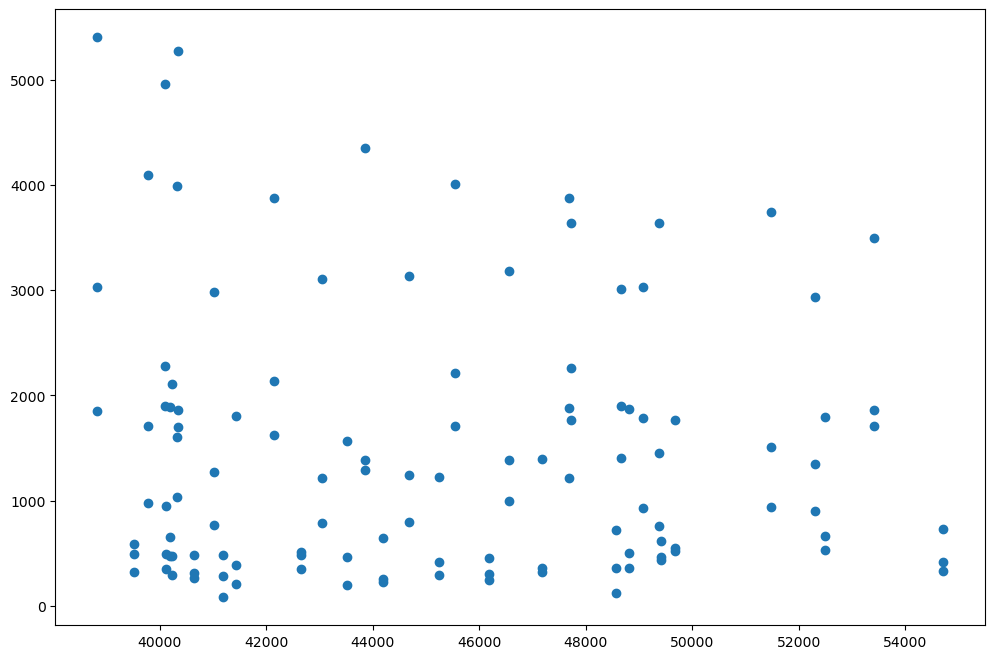

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(total_df["FRA_GDP"], total_df["France"], label="Data")
ax.plot(total_df["FRA_GDP"], ypred, "-o", label="Prediction (1)", color="orange")
# Label axes
ax.set_xlabel("Temperature")
ax.set_ylabel("Yield")
# Add a grid
ax.grid(True)
# Add a legend
ax.legend()

In [83]:
mse = np.mean((prediction - total_df["Belgium"]) ** 2)
mse # Display the MSE
X

/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,Herkunftsland - Total
87,930.0
75,4152.0
39,5723.0
46,6541.0
63,6572.0
...,...
103,50720.0
61,50799.0
73,52540.0
109,52757.0


In [84]:
ols1.score(X, y)



0.4961483088589772

In [85]:
# 2 degrees of polynomials, without the constant
poly2 = PolynomialFeatures(2, include_bias=False) 
# Define a new X with the squared feature
X2 = poly2.fit_transform(X)
X2[:5, :] # Check the first five rows of our new features

array([[9.3000000e+02, 8.6490000e+05],
       [4.1520000e+03, 1.7239104e+07],
       [5.7230000e+03, 3.2752729e+07],
       [6.5410000e+03, 4.2784681e+07],
       [6.5720000e+03, 4.3191184e+07]])

In [86]:
ols2 = LinearRegression()

In [87]:
# Fit the estimator 
ols2.fit(X2, y)
# Add the predictions to our `crops` dataframe
prediction["pred1"] = ols2.predict(X2)

/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/ipykernel_34729/3841582077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction["pred1"] = ols2.predict(X2)


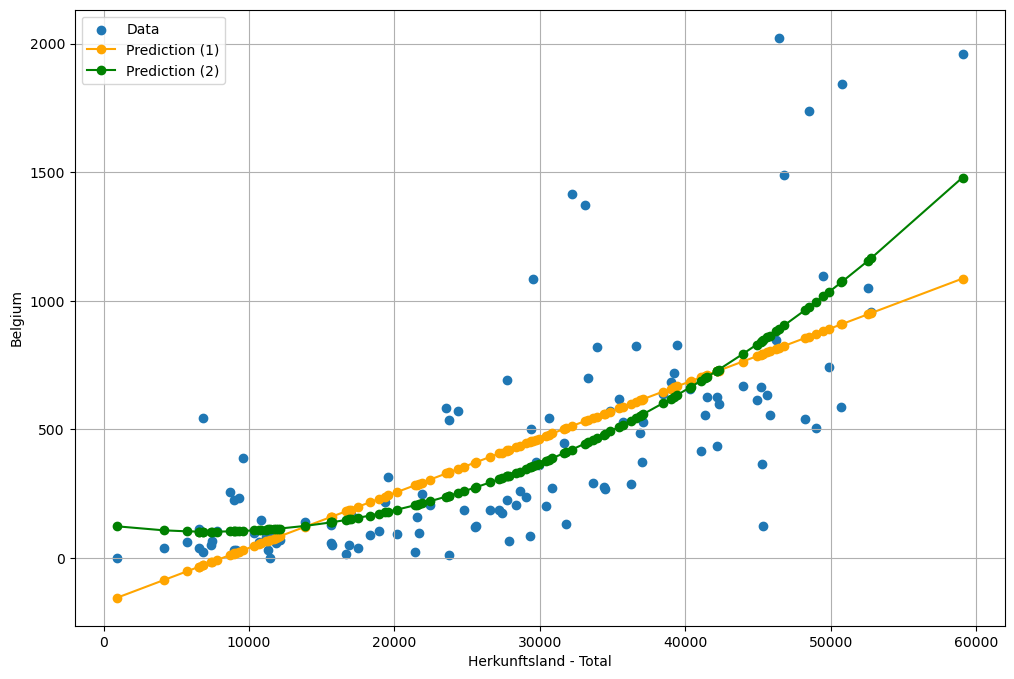

In [89]:
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(prediction["Herkunftsland - Total"], prediction["Belgium"], label="Data")
ax.plot(prediction["Herkunftsland - Total"], prediction["pred"], "-o", label="Prediction (1)", color="orange")
ax.plot(prediction["Herkunftsland - Total"], prediction["pred1"], "-o", label="Prediction (2)", color="green")
# Label axes
ax.set_xlabel("Herkunftsland - Total")
ax.set_ylabel("Belgium")
# Add a grid
ax.grid(True)
# Add a legend
ax.legend()

In [79]:
prediction

,Herkunftsland - Total,Belgium,pred,pred1
87,930.0,0.0,-154.314647,123.306907
75,4152.0,38.0,-85.535318,107.638790
39,5723.0,62.0,-51.999524,103.865724
46,6541.0,38.0,-34.537857,102.904600
63,6572.0,112.0,-33.876107,102.881690
...,...,...,...,...
103,50720.0,587.0,908.541599,1071.774139
61,50799.0,1842.0,910.227995,1075.302009
73,52540.0,1050.0,947.392741,1154.676186
109,52757.0,957.0,952.024993,1164.787639


/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/ipykernel_34729/1660731185.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction["pred2"] = ols3.predict(X3)


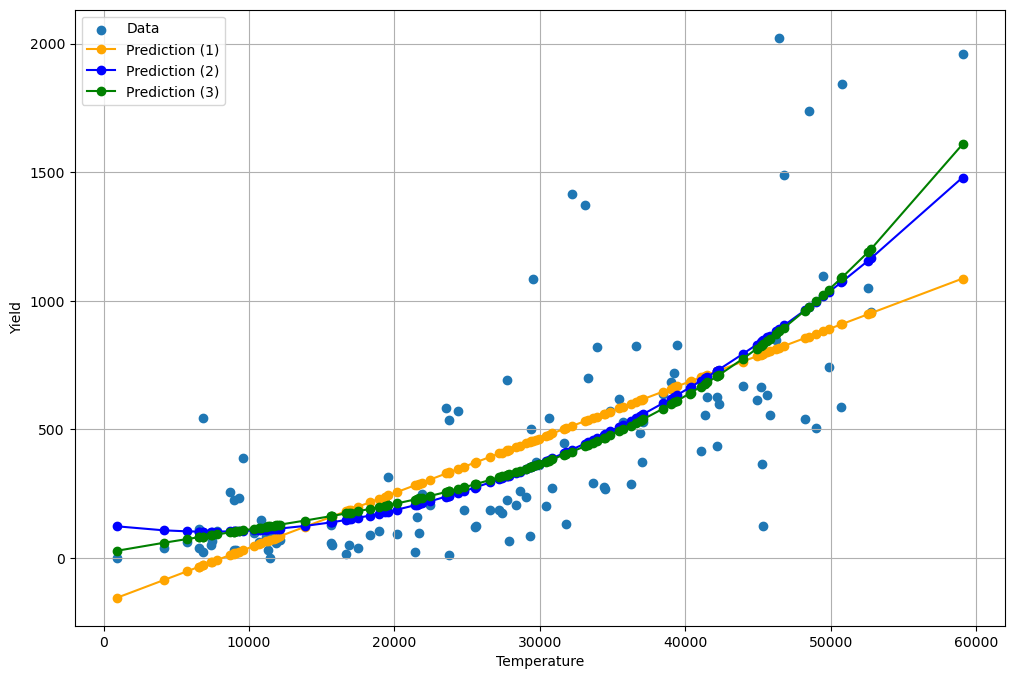

In [90]:
standardize = lambda x: (x-x.mean())/x.std()
# 3 degrees of polynomials, without the constant
poly3 = PolynomialFeatures(3, include_bias=False) 
X2 = standardize(X)
# Define a new X with the squared feature
X3 = poly3.fit_transform(X2)
X3 = np.apply_along_axis(standardize,0, X3)

X3[:5, :] # Check the first five rows of our new features
np.apply_along_axis(standardize,0, X3)

ols3 = LinearRegression()
# Fit the estimator 
ols3.fit(X3, y)
# Add the predictions to our `crops` dataframe
prediction["pred2"] = ols3.predict(X3)

# Visualize our predictions
# Set up the canvas
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(prediction["Herkunftsland - Total"], prediction["Belgium"], label="Data")
ax.plot(prediction["Herkunftsland - Total"], prediction["pred"], "-o", label="Prediction (1)", color="orange")
ax.plot(prediction["Herkunftsland - Total"], prediction["pred1"], "-o", label="Prediction (2)", color="blue")
ax.plot(prediction["Herkunftsland - Total"], prediction["pred2"], "-o", label="Prediction (3)", color="green")
# Label axes
ax.set_xlabel("Temperature")
ax.set_ylabel("Yield")
# Add a grid
ax.grid(True)
# Add a legend
ax.legend()

In [31]:
prediction["pred2"]

0      605.034102
1      881.038611
2      453.782179
3       83.437678
4      104.960715
          ...    
112    163.213202
113    317.066546
114    851.166478
115    829.963272
116    374.677638
Name: pred2, Length: 117, dtype: float64